# **Прогнозирование оттока клиентов банка и расчет экономической эффективности**

Предоставлены данные с оттоком клиентов банка. Необходимо спрогнозировать, уйдет клиент или нет.

Провести эксперименты с моделями:
- логистическая регрессия;
- бустинг.

Обучить 2-3 модели, подобрать гиперпараметры.

Рассчитать экономическую эффективность, исходя из трат бизнеса:
- 1 доллар - на удержание клиента;
- 2 доллара - с каждого правильно классифицированного (True Positive).

Сравнить модели по метрикам и показателю экономической эффективности.

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_recall_curve, precision_score, roc_auc_score
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import StandardScaler
warnings.filterwarnings("ignore")

# Загрузка и просмотр данных

In [ ]:
!wget 'https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91' -O churn_data.csv

--2023-11-23 12:30:11--  https://drive.google.com/uc?export=download&id=1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91
Resolving drive.google.com (drive.google.com)... 173.194.217.101, 173.194.217.102, 173.194.217.113, ...
Connecting to drive.google.com (drive.google.com)|173.194.217.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5nkpahkjio2p9ceutl30ju946gqftq8r/1700742600000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=d397cab1-ca97-46d0-9ceb-de508e74e479 [following]
--2023-11-23 12:30:12--  https://doc-14-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/5nkpahkjio2p9ceutl30ju946gqftq8r/1700742600000/14904333240138417226/*/1yIIxDfW7Wfq-wPlbsa0dFrSlD3r-Ai91?e=download&uuid=d397cab1-ca97-46d0-9ceb-de508e74e479
Resolving doc-14-c0-docs.googleusercontent.com (doc-14-c0-docs.googleusercontent.com)... 74.125.26.132, 26

In [ ]:
df = pd.read_csv("churn_data.csv")
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


 **Датасет содержит 13 переменных:**
 - RowNumber - номер строки,
-  CustomerId – идентификатор клиента,
- Surname – фамилия,
- CreditScore      - кредитный рейтинг,
- Geography         - страна,
- Gender – пол,
- Age – возраст,
- Tenure           - срок действия,
- Balance           - баланс,
- NumOfProducts – количество продуктов,
 - HasCrCard – имеет кредитных карт,
- IsActiveMember – является активным участником,
 - Estimated Salary  - предполагаемая зарплата.

**Целевая переменная:**
- Exited – отток.


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [ ]:
print(df.isnull().sum())

RowNumber          0
CustomerId         0
Surname            0
CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64


Датасет содержит 10000 строк. Пропусков нет, есть и количественные, и категориальные признаки.

Предположительно, признаки 'HasCrCard' и 'IsActiveMember' являются категориальными. Проверим количество значений признаков, чтобы убедиться  в этом.

In [ ]:
df.HasCrCard.value_counts()

,count
HasCrCard,
1,7055
0,2945


In [ ]:
df.IsActiveMember.value_counts()

,count
IsActiveMember,
1,5151
0,4849


Эти признаки являются бинарными. Приведем их к типу object для корректной обработки.

In [ ]:
df = df.astype({'HasCrCard': 'object', 'IsActiveMember': 'object'})

Удалим столбцы 'RowNumber', 'CustomerId', 'Surname', так как они не несут полезной информации для модели.

In [ ]:
df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1, inplace = True)

Определим категориальные и количественные признаки.

In [ ]:
continuous_columns = list(df.select_dtypes(include='number').columns.drop('Exited'))
continuous_columns

['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [ ]:
df.describe()

In [ ]:
categorical_columns = list(df.select_dtypes(include=['object']).columns)
categorical_columns

['Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [ ]:
df.describe(include='object')

Проверим распределение классов.

In [ ]:
df['Exited'].value_counts()

,count
Exited,
0,7963
1,2037


In [ ]:
df['Exited'].value_counts(normalize=True)*100

,proportion
Exited,
0,79.63
1,20.37


Видим, что присутствует явный дисбаланс: в датасете представлено 80% 0-го класса, и 20% объектов имеют класс 1.

Разделим данные на train и test с учетом дисбаланса.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], stratify=df['Exited'], random_state=0)

Убедимся, что соотношение классов в наборах данных такое же, как и в общем датасете.

In [ ]:
X_train['Exited'].value_counts(normalize=True)*100

,proportion
Exited,
0,79.626667
1,20.373333


In [ ]:
X_test['Exited'].value_counts(normalize=True)*100

,proportion
Exited,
0,79.64
1,20.36


Соотношение классов осталось прежним.

Создадим классы для предобработки данных. Класс FeatureSelector будет выбирать столбец и передавать его на следующий шаг pipeline. Класс  NumberSelector будет выбирать числовой столбец, класс OHEEncoder будет выполнять дамми-кодирование категориальных признаков.

In [ ]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]


class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]


class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]

        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

Создадим общий трансформер, в который передадим категориальные преобразованные признаки и числовые стандартизированные признаки.

In [ ]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])

    final_transformers.append((cat_col, cat_transformer))

for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', StandardScaler())
            ])

    final_transformers.append((cont_col, cont_transformer))

Объединим в итоговый pipeline.

In [ ]:
feats = FeatureUnion(final_transformers)
feature_processing = Pipeline([('feats', feats)])

Создадим функции для дальнейшей работы:
- get_metrics - будет возвращать наилучший порог разделения данных;
- plot_confusion_matrix  и show_matrix – будут визуализировать матрицу ошибок;
- economic_efficiency – будет рассчитывать экономическую эффективность: возвратит разницу между суммой, потраченной на удержание и суммой, заработанной на тех, кого удержали.


In [ ]:
def get_metrics(probs):
    precision, recall, thresholds = precision_recall_curve(y_test, probs)
    fscore = (2 * precision * recall) / (precision + recall)
    ix = np.argmax(fscore)
    print(f'Best Threshold={thresholds[ix]}, F-Score={fscore[ix]:.3f}, Precision={precision[ix]:.3f}, Recall={recall[ix]:.3f}')
    return thresholds[ix]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def show_matrix(preds, thresholds):
  font = {'size' : 15}
  plt.rc('font', **font)
  cnf_matrix = confusion_matrix(y_test, preds > thresholds)
  plt.figure(figsize=(6, 4))
  plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'], title='Confusion matrix')
  plt.savefig("conf_matrix.png")
  plt.show()
  return cnf_matrix

In [ ]:
def economic_efficiency(cnf_matrix):
  TN = cnf_matrix[0][0]
  FP = cnf_matrix[0][1]
  FN = cnf_matrix[1][0]
  TP = cnf_matrix[1][1]
  retain_sum = (FP + TP) * 1
  income = TP * 2
  total = income - retain_sum
  return total

# Обучение моделей

## LogisticRegression

 Обучим базовую модель логистической регрессии.

In [ ]:
pipeline_lr_ = Pipeline([
    ('features', feats),
    ('logreg', LogisticRegression(random_state=42)),
])

In [ ]:
pipeline_lr_.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='H...
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='Balance')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('logreg', LogisticRegression(random_state=42))])

In [ ]:
preds_logreg_  = pipeline_lr_.predict_proba(X_test)[:, 1]
print(f'Прогнозы для тестовой выборки: {preds_logreg_[:10]}')
thresholds_logreg_ = get_metrics(preds_logreg_)
roc_auc_logreg_  = roc_auc_score(y_test, preds_logreg_)
print(f'roc_auc: {roc_auc_logreg_}')

Прогнозы для тестовой выборки: [0.0985946  0.30036887 0.05266645 0.18190039 0.20231025 0.02571347
 0.11577434 0.19078278 0.12272975 0.07985912]
Best Threshold=0.2598487294490571, F-Score=0.495, Precision=0.428, Recall=0.585
roc_auc: 0.7704108567137581


Метрики базовой модели достаточно низкие.

Построим матрицу ошибок.


Confusion matrix, without normalization
[[1593  398]
 [ 212  297]]


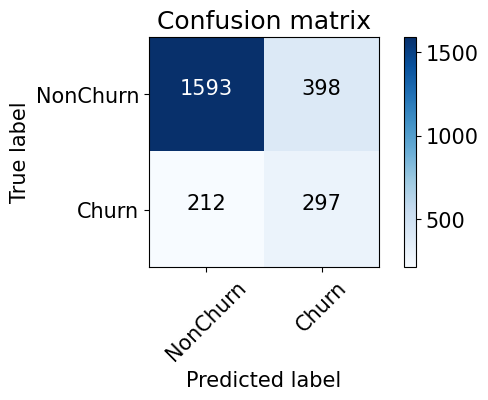

In [ ]:
matrix_logreg_ = show_matrix(preds_logreg_, thresholds_logreg_)

Модель правильно предсказала 1593 клиента, которые не уйдут в отток и 297 клиентов, которые уйдут в отток. Модель ошибочно посчитала, что 212 клиентов не уйдут в отток, и 398 клиентов уйдут в отток.

Проверим, на сколько модель экономически эффективна.

In [ ]:
el_ = economic_efficiency(matrix_logreg_)
print(el_)

-101


Экономическая эффективность отрицательная. Попробуем подобрать гиперпараметры, чтобы улучшить предсказания модели.

In [ ]:
pipeline_lr = Pipeline([
    ('features', feats),
    ('logreg', LogisticRegression()),
])

In [ ]:
param_grid_lr = {
    'logreg__penalty': ['l1', 'l2', 'elasticnet', None],
    'logreg__max_iter': [5, 10, 15],
    'logreg__solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'logreg__C':  [.001, .01, .1, 1, 10, 100, 1000],
    'logreg__l1_ratio': [0, 0.5, 1]
}

In [ ]:
%%time
grid_lr = GridSearchCV(pipeline_lr,
                    param_grid=param_grid_lr,
                    cv=5)

search_lr = grid_lr.fit(X_train, y_train)
search_lr.best_params_

CPU times: user 9min 59s, sys: 1.52 s, total: 10min 1s
Wall time: 8min 36s


{'logreg__C': 10,
 'logreg__l1_ratio': 0,
 'logreg__max_iter': 5,
 'logreg__penalty': None,
 'logreg__solver': 'sag'}

Передадим лучшие гиперпараметры в pipeline.

In [ ]:
pipeline_lr = Pipeline([
    ('features', feats),
    ('logreg', LogisticRegression(penalty=search_lr.best_params_['logreg__penalty'],
                                  max_iter=search_lr.best_params_['logreg__max_iter'],
                                  solver=search_lr.best_params_['logreg__solver'],
                                  C=search_lr.best_params_['logreg__C'],
                                  l1_ratio=search_lr.best_params_['logreg__l1_ratio'],
                                  random_state=42)),
])

In [ ]:
pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='H...
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('logreg',
                 LogisticRegression(C=10, l1_ratio=0, max_iter=5, penalty=None,
                                    random_state=42, solver='sag'))])

In [ ]:
preds_logreg  = pipeline_lr.predict_proba(X_test)[:, 1]
print(f'Прогнозы для тестовой выборки: {preds_logreg[:10]}')
thresholds_logreg = get_metrics(preds_logreg)
roc_auc_logreg  = roc_auc_score(y_test, preds_logreg)
print(f'roc_auc: {roc_auc_logreg}')

Прогнозы для тестовой выборки: [0.06127779 0.27102562 0.03767251 0.19634621 0.22512662 0.01344821
 0.0940086  0.28068578 0.10190016 0.03762118]
Best Threshold=0.25434630476208353, F-Score=0.488, Precision=0.412, Recall=0.599
roc_auc: 0.765424765077426


Видим, что метрики остались примерно на прежнем уровне. Выведем матрицу ошибок.

Confusion matrix, without normalization
[[1556  435]
 [ 205  304]]


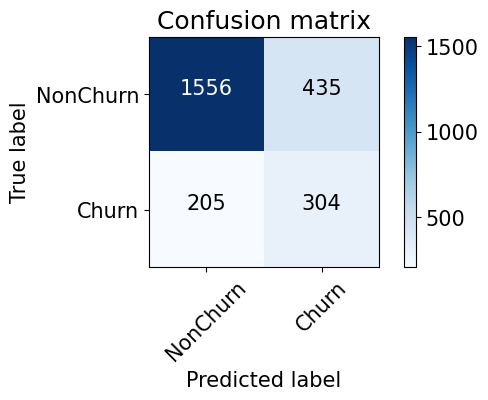

In [ ]:
matrix_logreg = show_matrix(preds_logreg, thresholds_logreg)

Модель правильно предсказала 1556 клиентов, которые не уйдут в отток и 304 клиента, которые уйдут в отток. Модель ошибочно посчитала, что 205 клиентов не уйдут в отток, и 435 клиентов уйдут в отток. Таким образом, модель стала хуже определять тех, кто на самом деле не уйдут в отток. Снизилось количество ошибок FP, но увеличилось количество ошибок FN.

Сравним экономическую эффективность модели с предыдущей.


In [ ]:
el_ = economic_efficiency(matrix_logreg_)
print(el_)

-48

Хотя экономическая эффективность до сих пор остается отрицательной, модель с подбором параметров улучшила показатель.

Видимо, модель логистической регрессии плохо подходит для этих данных: данные являются несбалансированными, и подбор параметров и добавление регуляризации не могут дать необходимое качество.

## Градиентный бустинг

Вероятно, для наших данных больше подойдет модель, более устойчивая к дисбалансу классов. Попробуем модель градиентного бустинга для прогнозирования оттока. Найдем наилучшие параметры модели.

In [ ]:
pipeline_gb = Pipeline([
    ('features', feats),
    ('gradboost', GradientBoostingClassifier()),
])

In [ ]:
params_gb = {
    'gradboost__loss': ['log_loss', 'exponential'],
    'gradboost__learning_rate': [0.01, 0.05, 0.1, 0.5],
    'gradboost__n_estimators': [10, 50, 100, 200],
    'gradboost__criterion': ['friedman_mse', 'squared_error'],
    'gradboost__max_depth': [None, 1, 3, 5],
    'gradboost__min_samples_split': range(100, 150, 200)
}

In [ ]:
%%time
grid = GridSearchCV(pipeline_gb,
                    param_grid=params_gb,
                    cv=6)

search = grid.fit(X_train, y_train)
search.best_params_

CPU times: user 1h 2min 50s, sys: 3.07 s, total: 1h 2min 53s
Wall time: 1h 3min 17s


{'gradboost__criterion': 'friedman_mse',
 'gradboost__learning_rate': 0.05,
 'gradboost__loss': 'log_loss',
 'gradboost__max_depth': 3,
 'gradboost__min_samples_split': 100,
 'gradboost__n_estimators': 200}

In [ ]:
pipeline_gb = Pipeline([
    ('features', feats),
    ('gradboost', GradientBoostingClassifier(loss=search.best_params_['gradboost__loss'],
                                             learning_rate=search.best_params_['gradboost__learning_rate'],
                                             n_estimators=search.best_params_['gradboost__n_estimators'],
                                             criterion=search.best_params_['gradboost__criterion'],
                                             max_depth=search.best_params_['gradboost__max_depth'],
                                             min_samples_split=search.best_params_['gradboost__min_samples_split'])),
])
pipeline_gb.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('HasCrCard',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='H...
                                                                  StandardScaler())])),
                                                ('NumOfProducts',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='NumOfProducts')),
                                                                 ('standard',
                                                                  StandardScaler())])),
                                                ('EstimatedSalary',
                                                 Pipeline(steps=[('selector',
                                                                  NumberSelector(key='EstimatedSalary')),
                                                                 ('standard',
                                                                  StandardScaler())]))])),
                ('gradboost',
                 GradientBoostingClassifier(learning_rate=0.05,
                                            min_samples_split=100,
                                            n_estimators=200))])

In [ ]:
preds_gb  = pipeline_gb.predict_proba(X_test)[:, 1]
print(f'Прогнозы для тестовой выборки: {preds_gb[:10]}')
thresholds_gb = get_metrics(preds_gb)
roc_auc_gb  = roc_auc_score(y_test, preds_gb)
print(f'roc_auc: {roc_auc_gb}')

Прогнозы для тестовой выборки: [0.02569591 0.11363765 0.02465573 0.04376317 0.22689973 0.01439479
 0.14040222 0.15050524 0.1929248  0.03653419]
Best Threshold=0.3054346088129861, F-Score=0.617, Precision=0.620, Recall=0.613
roc_auc: 0.8570877396220122


Модель показывает лучшие метрики по сравнению с логистической регрессией. Построим матрицу ошибок.

Confusion matrix, without normalization
[[1800  191]
 [ 198  311]]


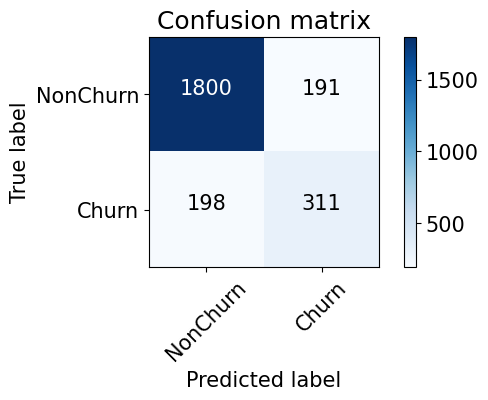

In [ ]:
matrix_gb = show_matrix(preds_gb, thresholds_gb)

Модель правильно предсказала 1800 клиентов, которые не уйдут в отток и 311 клиентов, которые уйдут в отток. Модель ошибочно посчитала, что 198 клиентов не уйдут в отток, и 191 клиент уйдут в отток. Данная модель значительно лучше предсказывает истинно положительные и отрицательные метки. Также видим существенное снижение ошибок FN и FP.

Рассчитаем экономическую эффективность модели.


In [ ]:
e_l = economic_efficiency(matrix_gb)
print(e_l)

120


Экономическая эффективность модели положительна, и намного превышает отрицательную эффективность предыдущих моделей. Такую модель можно использовать для прогнозирования оттока.

# Выводы

В ходе работы был выполнен разведочный анализ данных и проведено обучение моделей логистической регрессии и градиентного бустинга.

Сначала было произведено обучение логистической регрессии без подбора гиперпараметров, результаты по метрикам Best Threshold=0.26, F-Score=0.495, Precision=0.428, Recall=0.585, roc_auc: 0.77. При этом модель оказалась экономически не эффективной - модель не дала прироста денег, значение получилось отрицательным -101.

Далее был произведен подбор гиперпараметров для логистической регрессии, результаты по метрикам немного ухудшились: Best Threshold=0.254, F-Score=0.488, Precision=0.412, Recall=0.599, roc_auc: 0.765. При этом модель оказалась более экономически эффективной, чем предыдущая, но также не дала прирост денег -48.

Далее была обучена модель градиентного бустинга с подбором гиперапаметров. Результаты по метрикам получились самыми высокими Best Threshold=0.305, F-Score=0.617, Precision=0.620, Recall=0.613, roc_auc: 0.86. Данная модель экономически эффективна - дала прирост денег 120.  

Данная модель будет уменьшать потери бизнеса и приносить ему прибыль.